<a href="https://colab.research.google.com/github/EricKenjiLee/WaveMAP_Paper/blob/main/WaveMAP_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import all packages

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import datasets
from PIL import Image
from io import BytesIO
import base64


from bokeh.plotting import figure, show, output_notebook, output_file
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper, ContinuousColorMapper
from bokeh.palettes import Turbo256
from bokeh.transform import linear_cmap
from bokeh.transform import factor_cmap

# from scipy.io import loadmat

from os.path import dirname, join as pjoin
import scipy.io as sio

from umap import umap_ as umap
import networkx as nx
import igraph as ig

import matplotlib.pyplot as plt

## ECG needs to be defined and added manually to iGraph

In [3]:
def community_ecg(self, weights=None, ens_size=16, min_weight=0.05):
    W = [0]*self.ecount()
    ## Ensemble of level-1 Louvain 
    for i in range(ens_size):
        p = np.random.permutation(self.vcount()).tolist()
        g = self.permute_vertices(p)
        l = g.community_multilevel(weights=weights, return_levels=True)[0].membership
        b = [l[p[x.tuple[0]]]==l[p[x.tuple[1]]] for x in self.es]
        W = [W[i]+b[i] for i in range(len(W))]
    W = [min_weight + (1-min_weight)*W[i]/ens_size for i in range(len(W))]
    ## Force min_weight outside 2-core
    core = self.shell_index()
    ecore = [min(core[x.tuple[0]],core[x.tuple[1]]) for x in self.es]
    w = [W[i] if ecore[i]>1 else min_weight for i in range(len(ecore))]
    part = self.community_multilevel(weights=w)
    part.W = w
    part.CSI = 1-2*np.sum([min(1-i,i) for i in w])/len(w)
    return part

ig.Graph.community_ecg = community_ecg

## Loading the waveform data

In [4]:
data_dir = 'data'

mat_fname = pjoin(data_dir, 'waveforms_mean.mat')
fmnist = sio.loadmat(mat_fname)
fmnist_subset = fmnist["waveforms_mean"]


(363, 181)

(363, 181)

### Check if imported correctly by checking size and plotting a sample waveform

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Mon Apr 22 18:05:27 2024', '__version__': '1.0', '__globals__': [], 'waveforms_mean': array([[ 4.70754178e-04,  2.42846286e-04, -8.89483585e-04, ...,
         2.45911089e-03,  1.84625931e-03,  1.56109878e-03],
       [-1.07406817e-02, -9.27138592e-03, -1.24864166e-02, ...,
         1.14791765e-02,  9.45244008e-03,  7.05604667e-03],
       [ 2.87770643e-03,  5.49427471e-03,  7.18267212e-03, ...,
        -7.80586789e-03, -6.33149576e-03, -5.73692042e-03],
       ...,
       [-4.86613723e-03, -3.92767319e-03, -3.16277983e-03, ...,
         4.92142149e-03,  5.11245325e-03,  4.18614080e-03],
       [ 1.13098516e-05,  1.42583236e-03, -8.10931329e-05, ...,
        -1.09585835e-03, -3.38861542e-03, -6.13013201e-03],
       [ 8.19716275e-04,  2.50860019e-03,  5.41449440e-03, ...,
        -9.89278940e-03, -7.54197204e-03, -7.43043752e-03]])}
{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Mon Apr 22 18:05:2

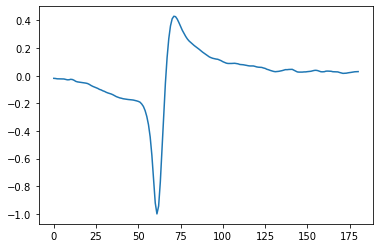

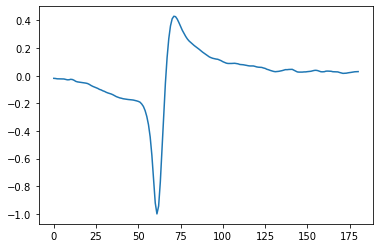

In [5]:
print(f"{fmnist_subset.shape[0]} units, {fmnist_subset.shape[1]} samples")

plt.plot(fmnist["waveforms_mean"][3])
# plt.plot(fmnist["waveforms"][3])

## Compute UMAP step of WaveMAP



In [6]:
reducer = umap.UMAP()
mapper = reducer.fit(fmnist_subset)
embedding = reducer.transform(fmnist_subset)


## Calculate ECG of UMAP high-dimensional graph

In [7]:
G = nx.from_scipy_sparse_matrix(mapper.graph_)
umap_igraph = ig.Graph(len(G), list(zip(*list(zip(*nx.to_edgelist(G)))[:2])))

umap_ECG = umap_igraph.community_ecg(ens_size=10,min_weight=0.5)

In [8]:
mapper.graph_.shape
embedding.shape
print(dir(mapper))

['__add__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__sub__', '__subclasshook__', '__weakref__', '_a', '_b', '_check_custom_metric', '_check_feature_names', '_check_n_features', '_densmap_kwds', '_disconnection_distance', '_fit_embed_data', '_get_param_names', '_get_tags', '_initial_alpha', '_input_distance_func', '_input_hash', '_inverse_distance_func', '_metric_kwds', '_more_tags', '_n_neighbors', '_original_n_threads', '_output_distance_func', '_output_metric_kwds', '_populate_combined_params', '_raw_data', '_repr_html_', '_repr_html_inner', '_repr_mimebundle_', '_rhos', '_sigmas', '_small_data', '_sparse_data', '_supervised', '_target_metric_kwds', '_validate_data', '_valida

## Plot WaveMAP i.e. UMAP with ECG clusters

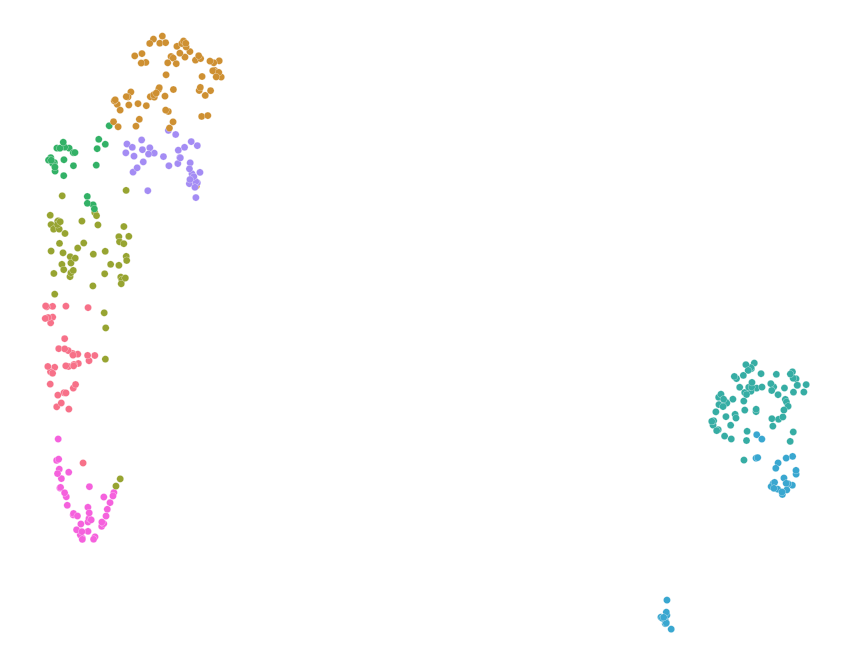

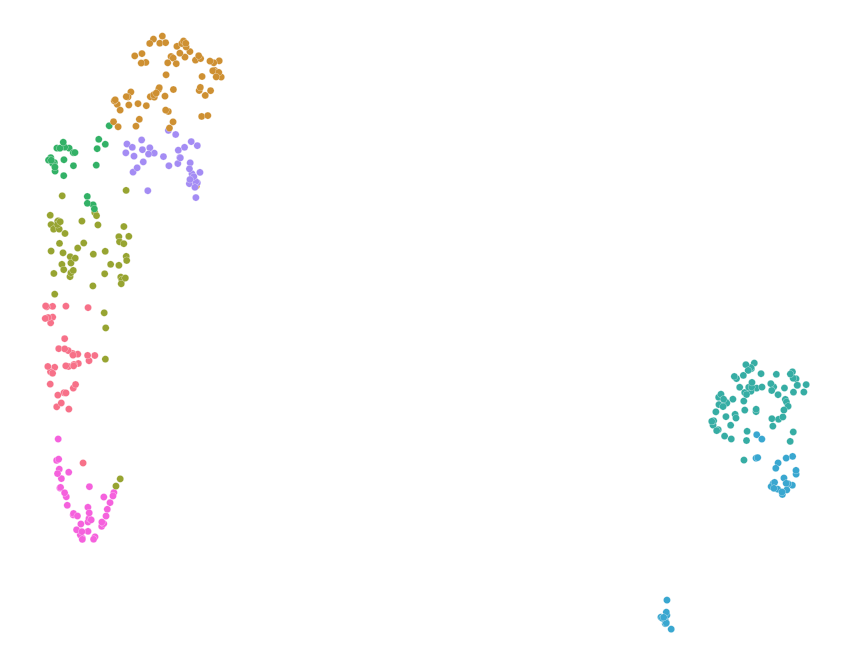

In [9]:
umap_df = pd.DataFrame(embedding, columns=('x', 'y'))
umap_df['color'] = umap_ECG.membership

ecg_colormap = [sns.color_palette("husl", len(set(umap_ECG.membership)))[i] for i in umap_ECG.membership]

f, arr = plt.subplots(1,figsize=[15,12])

arr.scatter(umap_df['x'].tolist(), umap_df['y'].tolist(), 
            marker='o',c=ecg_colormap, s=50, edgecolor='w',
            linewidth=0.25)

arr.spines['top'].set_visible(False)
arr.spines['left'].set_visible(False)
arr.spines['right'].set_visible(False)
arr.spines['bottom'].set_visible(False)

arr.set_xticks([])
arr.set_yticks([])

plt.savefig('wavemap_scatter_all.pdf')


## check number of clusters

In [10]:
# print(max(umap_df[colors]))
umap_df.shape
print(umap_df.iloc[:, 2].max())

7

7

## save clustering to csv

In [11]:
umap_df.to_csv(pjoin('analysis_output', 'waveforms_mean.mat'))

